# Scientific Abstract Summarization - Project Code

Working notebook for CSC791 project exploring extractive vs. abstractive summarization of arXiv abstracts. The dataset expected here is `~/arxiv-metadata.csv` with columns `title`, `summary`, and `category`. Cells are tuned for modest hardware; adjust sampling/config to scale.


## Notebook map
- Imports and configuration
- Data loading and lightweight preprocessing
- Extractive baselines (Lead-k, TF-IDF sentence scoring)
- Optional abstractive hook (only if transformers are available locally)
- Evaluation helpers (ROUGE-n, ROUGE-L, embedding cosine)
- Small sample run to verify the pipeline


In [72]:
import os
os.environ.setdefault('HF_HUB_OFFLINE', '1')
os.environ.setdefault('TRANSFORMERS_OFFLINE', '1')
import re
import math
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Optional

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Optional dependencies; the notebook runs without them.
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    SentenceTransformer = None

try:
    from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
except ImportError:
    pipeline = None
    AutoTokenizer = None
    AutoModelForSeq2SeqLM = None


In [73]:
# Paths and runtime knobs
DATA_PATH = Path("arxiv-metadata.csv")  # adjust if the dataset lives elsewhere
MODEL_CACHE_DIR = Path("hf_models")
EMBED_MODEL_PATH = MODEL_CACHE_DIR / "sentence-transformers_all-MiniLM-L6-v2"
ABSTRACTIVE_MODEL_NAME = str(MODEL_CACHE_DIR / "sshleifer_distilbart-cnn-12-6")
MAX_ROWS = 20000  # upper bound read from disk for quick iteration
SAMPLE_SIZE = 5000  # random subset taken from MAX_ROWS to keep runtime low
PER_CATEGORY_LIMIT = None  # e.g., 800 to cap per-category counts; None keeps all
FOCUS_PREFIXES: List[str] = []  # e.g., ['cs.', 'math.'] to filter categories; empty means all
MIN_WORDS = 30  # filter out abstracts shorter than this
RANDOM_STATE = 42

# Evaluation batch size
EVAL_ROWS = 40  # number of abstracts to score when smoke-testing methods
RESULTS_PATH = Path("eval_results_sample.csv")

# Flags for optional components
USE_SENTENCE_EMBEDDINGS = True
USE_ABSTRACTIVE = True

os.environ.setdefault("HF_HOME", str(MODEL_CACHE_DIR.resolve()))

print(f"Using dataset at: {DATA_PATH}")


Using dataset at: arxiv-metadata.csv


## Imports and environment
Sets offline flags, imports dependencies, and pulls in optional transformer utilities.


In [74]:
def normalize_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", str(text)).strip()

def split_sentences(text: str) -> List[str]:
    text = normalize_whitespace(text)
    # Simple sentence splitter; replace if you add spaCy or NLTK later.
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s for s in sentences if s]

def load_arxiv_dataset(
    path: Path = DATA_PATH,
    max_rows: int = MAX_ROWS,
    sample_size: int = SAMPLE_SIZE,
    min_words: int = MIN_WORDS,
    random_state: int = RANDOM_STATE,
    focus_prefixes: Optional[List[str]] = None,
    per_category_limit: Optional[int] = PER_CATEGORY_LIMIT,
) -> pd.DataFrame:
    cols = ["id", "title", "category", "summary", "summary_word_count"]
    df = pd.read_csv(path, usecols=cols, nrows=max_rows)
    df["summary"] = df["summary"].apply(normalize_whitespace)
    df = df[df["summary"].str.split().str.len() >= min_words]
    df = df.dropna(subset=["category"])
    if focus_prefixes:
        df = df[df["category"].str.startswith(tuple(focus_prefixes))]
    if per_category_limit:
        df = df.groupby("category").head(per_category_limit).reset_index(drop=True)
    if sample_size and len(df) > sample_size:
        df = df.sample(sample_size, random_state=random_state)
    df = df.reset_index(drop=True)
    return df

# Extractive summarizers

def lead_k_summary(text: str, k: int = 1) -> str:
    sentences = split_sentences(text)
    return " ".join(sentences[:k]) if sentences else ""

def fit_tfidf_vectorizer(texts: Iterable[str], max_features: int = 8000) -> TfidfVectorizer:
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        stop_words="english",
    )
    vectorizer.fit(texts)
    return vectorizer

def tfidf_extractive_summary(
    text: str,
    vectorizer: TfidfVectorizer,
    max_sentences: int = 2,
) -> str:
    sentences = split_sentences(text)
    if not sentences:
        return ""
    doc_vec = vectorizer.transform([text])
    sent_vecs = vectorizer.transform(sentences)
    scores = cosine_similarity(sent_vecs, doc_vec)[:, 0]
    ranked_idx = np.argsort(scores)[::-1][:max_sentences]
    # Preserve original order for readability
    selected = [sentences[i] for i in sorted(ranked_idx)]
    return " ".join(selected)

def textrank_extractive_summary(
    text: str,
    vectorizer: TfidfVectorizer,
    max_sentences: int = 2,
    damping: float = 0.85,
    max_iter: int = 40,
    tol: float = 1e-4,
) -> str:
    sentences = split_sentences(text)
    if not sentences:
        return ""
    if len(sentences) <= max_sentences:
        return " ".join(sentences)
    sent_vecs = vectorizer.transform(sentences)
    sim = cosine_similarity(sent_vecs)
    np.fill_diagonal(sim, 0.0)
    row_sum = sim.sum(axis=1, keepdims=True)
    norm_sim = np.divide(sim, row_sum, out=np.zeros_like(sim), where=row_sum != 0)
    scores = np.ones(len(sentences)) / len(sentences)
    for _ in range(max_iter):
        prev = scores.copy()
        scores = (1 - damping) / len(sentences) + damping * norm_sim.T.dot(scores)
        if np.linalg.norm(scores - prev, 1) < tol:
            break
    ranked_idx = np.argsort(scores)[::-1][:max_sentences]
    selected = [sentences[i] for i in sorted(ranked_idx)]
    return " ".join(selected)

# Optional abstractive summarizer hook

def get_abstractive_summarizer(model_name: str = "facebook/bart-large-cnn"):
    if pipeline is None or AutoTokenizer is None or AutoModelForSeq2SeqLM is None:
        return None
    try:
        tok = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        mod = AutoModelForSeq2SeqLM.from_pretrained(model_name, local_files_only=True)
        return pipeline("summarization", model=mod, tokenizer=tok)
    except Exception as exc:  # network or missing weights
        print(f"Abstractive model unavailable: {exc}")
        return None

def abstractive_summary(
    text: str,
    summarizer,
    min_length: int = 20,
    max_length: int = 60,
) -> str:
    if summarizer is None:
        return ""
    result = summarizer(text, min_length=min_length, max_length=max_length)
    return result[0]["summary_text"] if result else ""


## Configuration
Paths, sampling knobs, flags for embeddings/abstractive models, and dataset settings.


In [75]:
# Evaluation metrics

def _tokenize(text: str) -> List[str]:
    return normalize_whitespace(text).lower().split()

def _ngram(tokens: List[str], n: int) -> List[tuple]:
    return [tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)]

def rouge_n(reference: str, candidate: str, n: int = 1) -> Dict[str, float]:
    ref_tokens = _tokenize(reference)
    cand_tokens = _tokenize(candidate)
    if not ref_tokens or not cand_tokens:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    ref_ngrams = _ngram(ref_tokens, n)
    cand_ngrams = _ngram(cand_tokens, n)
    ref_counts: Dict[tuple, int] = {}
    for ng in ref_ngrams:
        ref_counts[ng] = ref_counts.get(ng, 0) + 1
    overlap = 0
    for ng in cand_ngrams:
        if ref_counts.get(ng, 0) > 0:
            overlap += 1
            ref_counts[ng] -= 1
    precision = overlap / max(len(cand_ngrams), 1)
    recall = overlap / max(len(ref_ngrams), 1)
    f1 = 0.0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
    return {"precision": precision, "recall": recall, "f1": f1}

def _lcs_length(a: List[str], b: List[str]) -> int:
    # Classic dynamic-programming LCS for small sequences
    dp = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            if a[i - 1] == b[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[-1][-1]

def rouge_l(reference: str, candidate: str) -> Dict[str, float]:
    ref_tokens = _tokenize(reference)
    cand_tokens = _tokenize(candidate)
    if not ref_tokens or not cand_tokens:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    lcs = _lcs_length(ref_tokens, cand_tokens)
    precision = lcs / len(cand_tokens)
    recall = lcs / len(ref_tokens)
    f1 = 0.0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
    return {"precision": precision, "recall": recall, "f1": f1}

def embedding_cosine(
    reference: str,
    candidate: str,
    embedder: Optional[object] = None,
    vectorizer: Optional[TfidfVectorizer] = None,
) -> float:
    if embedder is not None:
        vecs = embedder.encode([reference, candidate], normalize_embeddings=True)
        return float(np.dot(vecs[0], vecs[1]))
    if vectorizer is not None:
        mat = vectorizer.transform([reference, candidate])
        sims = cosine_similarity(mat[0], mat[1])
        return float(sims[0, 0])
    return float("nan")

def evaluate_methods(
    df: pd.DataFrame,
    summarizers: Dict[str, Callable[[str], str]],
    vectorizer: Optional[TfidfVectorizer],
    embedder: Optional[object] = None,
    max_eval: int = EVAL_ROWS,
) -> pd.DataFrame:
    sample = df.sample(min(max_eval, len(df)), random_state=RANDOM_STATE)
    records = []
    for _, row in sample.iterrows():
        reference = row["summary"]
        for name, func in summarizers.items():
            summary = func(reference)
            r1 = rouge_n(reference, summary, n=1)
            r2 = rouge_n(reference, summary, n=2)
            rl = rouge_l(reference, summary)
            sim = embedding_cosine(reference, summary, embedder=embedder, vectorizer=vectorizer)
            records.append(
                {
                    "id": row["id"],
                    "category": row["category"],
                    "method": name,
                    "summary": summary,
                    "rouge1_f1": r1["f1"],
                    "rouge2_f1": r2["f1"],
                    "rougeL_f1": rl["f1"],
                    "embedding_cosine": sim,
                    "compression_ratio": len(_tokenize(summary)) / max(len(_tokenize(reference)), 1),
                }
            )
    return pd.DataFrame(records)


## Preprocessing and summarization helpers
Normalization, sentence splitting, data loader, extractive baselines (Lead-k, TF-IDF), TextRank, and abstractive helpers.


In [76]:
abstracts_df = load_arxiv_dataset(
    path=DATA_PATH,
    max_rows=MAX_ROWS,
    sample_size=SAMPLE_SIZE,
    min_words=MIN_WORDS,
    random_state=RANDOM_STATE,
    focus_prefixes=FOCUS_PREFIXES,
    per_category_limit=PER_CATEGORY_LIMIT,
)
print(f"Loaded {len(abstracts_df)} abstracts for experimentation")
abstracts_df.head()


Loaded 5000 abstracts for experimentation


,id,title,category,summary,summary_word_count
0,abs-2201.12769v4,MVP-Net: Multiple View Pointwise Semantic Segm...,Computer Vision and Pattern Recognition,Semantic segmentation of 3D point cloud is an ...,138
1,abs-2412.03884v1,A Unified Framework for Evaluating the Effecti...,Artificial Intelligence,The rapid advancement of deep learning has res...,209
2,abs-2112.09943v3,Data Augmentation through Expert-guided Symmet...,Machine Learning,Offline estimation of the dynamical model of a...,183
3,abs-2212.10375v2,Self-Adaptive In-Context Learning: An Informat...,Computation and Language (Natural Language Pro...,Despite the surprising few-shot performance of...,143
4,abs-1611.00274v1,Detecting Affordances by Visuomotor Simulation,Artificial Intelligence,"The term ""affordance"" denotes the behavioral m...",199


## Evaluation utilities
Lightweight ROUGE-1/2/L, embedding cosine, and evaluator to score methods on a sample.


In [77]:
tfidf_vectorizer = fit_tfidf_vectorizer(abstracts_df["summary"], max_features=8000)

# Optional: enable sentence embeddings if sentence-transformers is installed and weights are local.
embedder = None
if USE_SENTENCE_EMBEDDINGS and SentenceTransformer is not None:
    try:
        # Model choice keeps memory/cpu needs low; change if you have the weights cached.
        embedder = SentenceTransformer(str(EMBED_MODEL_PATH), local_files_only=True, device='cpu')
    except Exception as exc:
        print(f"Embedding model unavailable: {exc}")
        embedder = None

# Optional abstractive model: set USE_ABSTRACTIVE = False if transformers weights are present.
abstractive_model = None
if USE_ABSTRACTIVE:
    abstractive_model = get_abstractive_summarizer(model_name=ABSTRACTIVE_MODEL_NAME)


Device set to use mps:0


## Load dataset
Reads arXiv abstracts with filtering/sampling and shows the head.


In [78]:
summarizers = {
    "lead_1": lambda text: lead_k_summary(text, k=1),
    "lead_2": lambda text: lead_k_summary(text, k=2),
    "tfidf_top2": lambda text: tfidf_extractive_summary(text, tfidf_vectorizer, max_sentences=2),
    "textrank_top2": lambda text: textrank_extractive_summary(text, tfidf_vectorizer, max_sentences=2),
}
if abstractive_model is not None:
    summarizers["abstractive_bart"] = lambda text: abstractive_summary(text, abstractive_model)
print(f"Configured summarizers: {list(summarizers.keys())}")


Configured summarizers: ['lead_1', 'lead_2', 'tfidf_top2', 'textrank_top2', 'abstractive_bart']


## Fit vectorizer and load optional models
Builds TF-IDF, then (optionally) loads local sentence-transformer embeddings and abstractive model from cached paths.


In [79]:
results_df = evaluate_methods(
    df=abstracts_df,
    summarizers=summarizers,
    vectorizer=tfidf_vectorizer,
    embedder=embedder,
    max_eval=EVAL_ROWS,
)

print(results_df.head().to_string(index=False))
print("\nAverage scores by method:")
avg_tbl = (
    results_df.groupby("method")[['rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'embedding_cosine', 'compression_ratio']]
    .mean()
    .sort_values(by="rouge1_f1", ascending=False)
)
print(avg_tbl.round(3).to_string())


              id category           method                                                                                                                                                                                                                                                                                                                                                 summary  rouge1_f1  rouge2_f1  rougeL_f1  embedding_cosine  compression_ratio
abs-2302.09750v1 Robotics           lead_1                                                                                                                                                                                                                                  Learning Enabled Components (LEC) have greatly assisted cyber-physical systems in achieving higher levels of autonomy.   0.119522   0.112450   0.119522          0.240542           0.063559
abs-2302.09750v1 Robotics           lead_2                                            

## Visualize results
Bar and box plots for ROUGE and embedding scores across methods; images also saved to disk.


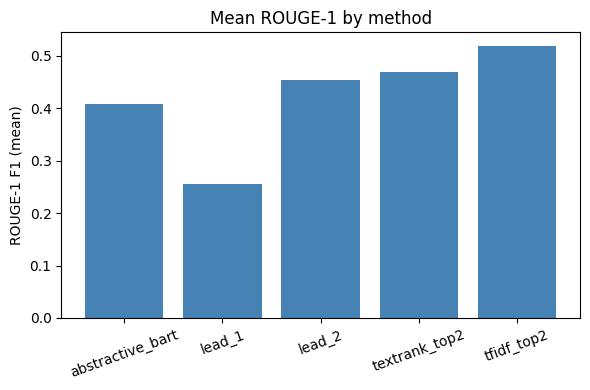

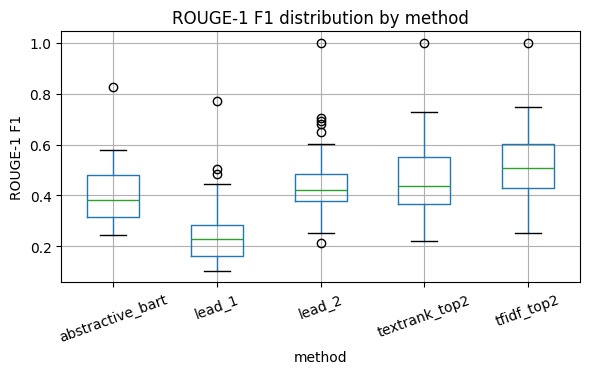

Saved plots: plot_rouge1_bar.png, plot_rouge1_box.png


In [80]:
import matplotlib.pyplot as plt

agg = results_df.groupby('method')[['rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'embedding_cosine']].mean().reset_index()

# Bar plot of mean ROUGE-1 F1
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(agg['method'], agg['rouge1_f1'], color='steelblue')
ax1.set_ylabel('ROUGE-1 F1 (mean)')
ax1.set_title('Mean ROUGE-1 by method')
plt.xticks(rotation=20)
plt.tight_layout()
fig1.savefig('plot_rouge1_bar.png', dpi=150)
plt.show()

# Box plot of ROUGE-1 F1 distribution
fig2, ax2 = plt.subplots(figsize=(6, 4))
results_df.boxplot(column='rouge1_f1', by='method', ax=ax2)
ax2.set_title('ROUGE-1 F1 distribution by method')
ax2.set_ylabel('ROUGE-1 F1')
plt.suptitle('')
plt.xticks(rotation=20)
plt.tight_layout()
fig2.savefig('plot_rouge1_box.png', dpi=150)
plt.show()

print('Saved plots: plot_rouge1_bar.png, plot_rouge1_box.png')


## Configure summarizers
Registers extractive baselines, TextRank, and optional abstractive summarizer.


In [81]:
# Persist evaluation sample for inspection/reporting
results_df.to_csv(RESULTS_PATH, index=False)
print(f"Saved evaluation sample to {RESULTS_PATH.resolve()}")


Saved evaluation sample to /Users/samferguson/CSC791/eval_results_sample.csv


## Run evaluation sample
Scores a sample of abstracts with each method and prints aggregate metrics.


In [82]:
per_category = results_df.groupby(['method', 'category'])[['rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'embedding_cosine', 'compression_ratio']].mean().reset_index()
print(per_category.round(3).head().to_string(index=False))
per_category.to_csv('eval_results_by_category.csv', index=False)
print('Saved per-category means to eval_results_by_category.csv')


          method                                               category  rouge1_f1  rouge2_f1  rougeL_f1  embedding_cosine  compression_ratio
abstractive_bart                                Artificial Intelligence      0.405      0.379      0.397             0.698              0.291
abstractive_bart Computation and Language (Natural Language Processing)      0.528      0.476      0.524             0.732              0.406
abstractive_bart                Computer Vision and Pattern Recognition      0.412      0.372      0.408             0.739              0.295
abstractive_bart                                       Machine Learning      0.405      0.375      0.403             0.621              0.288
abstractive_bart                                               Robotics      0.304      0.288      0.304             0.598              0.203
Saved per-category means to eval_results_by_category.csv
